<a href="https://colab.research.google.com/github/kdambrowski/Alien_Predator_recog_CV/blob/main/CV_alien_predator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle -q
! pip install validators -q
!pip install -q gradio
# !pip install -q gradio --upgrade
# !pip install -q --upgrade Flask
# !pip install -q --upgrade Pillow

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 94.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.9/287.9 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Library

In [3]:
import copy
import os
import os.path
from pathlib import Path
import random
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import drive
from google.colab.patches import cv2_imshow
import gradio as gr
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split as tts
from tqdm import tqdm, tqdm_notebook


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
from PIL import Image

# Clasess and functions

In [41]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = x.view(-1, 128 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        
        return img, label
    
    def __len__(self):
        return len(self.images)


def get_image_dataloader(images,
                         labels,
                         batch_size = 32,
                         shuffle=True,
                         num_workers = 2):
    dataset = ImageDataset(images, labels)
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            num_workers = num_workers)
    return dataloader

def download_unzip_file(file_name):
  if not os.path.isfile(file_name):
    !kaggle datasets download -d pmigdal/alien-vs-predator-images
    !unzip -q /content/alien-vs-predator-images.zip
    print(f'files have been downloaded and unzipped successfuly')
  else:
    print('directed file exist on selected path')

def jpg_file_renamed(folder_path, prefix, sufix_counter=False):
  """Changing name of files in indicated folder, add to regular name prefix
  and is possibility to add sufix_counter on the end of regular name.
  Sufix starts with 0 value
  """
  prefix_str = str(prefix)
  additional_slash = '/'
  folder_path_slash = folder_path + additional_slash
  folder_elements = os.listdir(folder_path_slash)
  if sufix_counter:
    sufix_counter = 0
    for file_name in folder_elements:
      source = folder_path_slash + file_name
      destination = folder_path_slash + prefix+"_" + file_name + str(sufix_counter)
      #result = ....ColoredDiceDataset/1/prefix000108sufix.jpg
      os.rename(source, destination)
      sufix_counter +=1
  else:          
    for file_name in folder_elements:
      source = folder_path_slash + file_name
      destination = folder_path_slash + prefix +"_" + file_name
      #result = ....ColoredDiceDataset/1/1000108.jpg
      os.rename(source, destination)
  previous_example_2_eg = sorted(folder_elements)[:2]
  results_2_eg= sorted(os.listdir(folder_path))[:2]
  return print('All files renamed successfully in indicated path',
               f'\nprevious name: {previous_example_2_eg}',
               f'\ncurrent name:{results_2_eg}\n')
   
def rename_files(root_path, searched_dir_name_1, searched_dir_name_2):  
  for root, dirs, files in os.walk(root_path):
    if searched_dir_name_1 in dirs:
      direct_path = os.path.join(root, searched_dir_name_1)
      jpg_file_renamed(direct_path, searched_dir_name_1[:2])
    if searched_dir_name_2 in dirs:
      direct_path = os.path.join(root, searched_dir_name_2)
      jpg_file_renamed(direct_path, searched_dir_name_2[:2])

def set_dimension_img(image, heigh, width):
  """function for set define dimennsion for picture"""
  picture_dimension = (heigh, width)
  return cv2.resize(image,picture_dimension)

def get_img_list(serched_path, img_id_df):
  img_list = []
  for img_id in img_id_df:
    for root, dir, file_name in os.walk(serched_path):
      if img_id in file_name:
        img_path = os.path.join(root, img_id)
        img_list.append(cv2.imread(img_path))
  return img_list

def manual_train_test_split(df, percentage):
  df_split_val = round(len(df)*percentage)
  if type(df) == 'pandas.core.frame.DataFrame':
    train_df = df[:df_split_val]
    test_df = df[df_split_val:]
  else:
    train_df = df[:df_split_val]
    test_df = df[df_split_val:]
  return train_df, test_df

# def val_pt_model(testing_pic):
#     if not testing_pic:
#         return "No image input provided"
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     loaded_model.to(device)
#     loaded_model.eval()
#     with torch.inference_mode():
#         inputs = pic_transformation(testing_pic)
#         inputs = inputs.to(device)
#         out = loaded_model(inputs)
#         pred_proba = torch.sigmoid(out) 
#         pred = torch.where(pred_proba > 0.5, 1,0).squeeze()
#         if pred:
#             pred = 'Predator'
#         else:
#             pred = 'Alien' 
#     return pred

def train_test_pt_model(model,
                        train_loader,
                        test_loader,
                        criterion,
                        optimizer,
                        epochs = 10):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  train_losses = []
  train_accs = []
  epochs_loop = []

  test_losses = []
  test_epoch_acc = []
  for epoch in range(epochs):
      progress_bar = tqdm_notebook(train_loader, leave=False)
      batch_losses = []
      test_batch_losses = []
      epochs_loop.append(epoch+1)
      acc, count, test_acc, test_count = 0, 0, 0, 0
      model.train()

      for inputs, target in progress_bar:
          inputs = inputs.view(-1, 1, 128, 128)
          inputs = inputs.to(device)
          target = target.to(device)

          model.zero_grad()
          output = model(inputs)
          loss = criterion(output.squeeze(), target.float())
          loss.backward()              
          nn.utils.clip_grad_norm_(model.parameters(), 3)
          optimizer.step()
          progress_bar.set_description(f'Loss: {loss.item():.3f}')
          batch_losses.append(loss.item())
          
          pred_proba = torch.sigmoid(output)
          pred = torch.where(pred_proba>0.5, 1,0).squeeze()
          acc += (pred == target).sum()
          count += len(target)

      model.eval()
      with torch.inference_mode():
        for test_input, test_target in test_loader:
          test_input = test_input.view(-1, 1, 128, 128)
          test_input = test_input.to(device)
          test_target = test_target.to(device)

          test_out = model(test_input).squeeze()
          test_pred = torch.round(torch.sigmoid(test_out))
          test_loss = criterion(test_out, test_target.float())
          test_batch_losses.append(test_loss.item())
          test_acc += (test_pred == test_target).sum()
          test_count += len(test_target)
    

      epoch_loss = sum(batch_losses) / len(batch_losses) 
      train_losses.append(epoch_loss)
      epoch_acc = (acc / count) * 100
      train_accs.append(epoch_acc.item())

      test_epoch_loss = sum(test_batch_losses) / len(test_batch_losses) 
      test_losses.append(test_epoch_loss)
      epoch_test_acc = (test_acc / test_count) * 100
      test_epoch_acc.append(epoch_test_acc.item())
      
      if not epoch % 10:
        tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.5f} \tTrain ACC: {epoch_acc:.5f}')
        tqdm.write(f'Epoch #{epoch + 1}\tTest Loss: {test_epoch_loss:.5f} \tTest ACC: {epoch_test_acc:.5f}\n')
  return train_losses, train_accs, test_losses, test_epoch_acc, epochs_loop

def draw_test_train_plot(train_losse, train_acc, test_loss = None, test_acc = None):
  epoch_range = range(1, len(train_losse)+1)
  acc_color = 'r'
  loss_color = 'b'
  if test_acc is not None and test_loss is not None: 
    fig, ax = plt.subplots(2,1, sharex = True)
    ax[0].set_title('Train_test LOSS and ACC plot throu trainings epochs')
    ax[0].plot(epoch_range, train_losse, label = 'train_loss', color = loss_color)
    ax[0].plot(epoch_range, test_loss, label = 'test_loss', color = loss_color, linestyle = '--')
    ax[0].set_ylabel('Loss value')
    ax[0].legend()

    ax[1].plot(epoch_range, train_acc, label = 'train_acc',  color = acc_color)
    ax[1].plot(epoch_range, test_acc, label = 'test_acc',  color = acc_color, linestyle = '--')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('ACC value')
    ax[1].legend()
  else:
    fig, ax = plt.subplots()
    plt.title('Train LOSS and ACC plot through trainings epochs')
    ax.plot(epoch_range, train_losses, label = 'train_loss', color = loss_color)
    ax.set_xlabel('epochs')
    ax.set_ylabel('Loss value')

    ax2=ax.twinx()
    ax2.plot(epoch_range, train_acc, label = 'train_acc', color = acc_color)

    ax2.set_ylabel('ACC value')
    ax2.tick_params('y', colors = acc_color)
    ax.legend()
    ax2.legend()

  plt.show()

def label_image_aug_sets(aug_num, labels_df, img_list, aug_propability):
  stacked_label_aug_times = pd.concat([labels_df] * aug_num,
                                       axis = 0,
                                       ignore_index = True)
  img_aug_list = img_list.copy()
  for seed_no in range(1, aug_num):
    iaa.ia.seed(seed_no)
    seq = iaa.Sequential([
            iaa.Sometimes(aug_propability,
                          iaa.Affine(rotate=(-25, 25))),
            iaa.Sometimes(aug_propability,
                          iaa.AdditiveGaussianNoise(scale=(10, 41))),
            iaa.Sometimes(aug_propability,
                          iaa.Crop(percent=(0, 0.2)))
        ])

    for aug_img in seq(images = img_list):
      img_aug_list.append(aug_img)
  return img_aug_list, stacked_label_aug_times

def save_model(model, dic_name, model_name):
    MODEL_PATH = Path(dic_name)
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    MODEL_SAVE_PATH = MODEL_PATH / (model_name + '.pth')
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    status = f'Model has been saved to: {MODEL_SAVE_PATH}'
    print(status)
    return str(MODEL_SAVE_PATH)

def load_model(model_class, saved_model_path):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  loaded_model = model_class
  loaded_model.load_state_dict(torch.load(saved_model_path))
  loaded_model.to(device)
  print(f"Loaded model structure:\n{loaded_model}\n\nModel on device:\n{next(loaded_model.parameters()).device}")
  return loaded_model

def mean_std_average_color(data_dir_train):
  image_datasets = datasets.ImageFolder(data_dir, transform=transforms.ToTensor())
  dataloader = torch.utils.data.DataLoader(image_datasets, batch_size=1, shuffle=False)
  data_img_mean = 0.
  data_img_std = 0.
  num_samples = len(image_datasets)

  for data in dataloader:
      img = data[0]
      batch_samples = img.size(0)
      channels = img.size(1)
      pixels = img.view(batch_samples, channels, -1)
      data_img_mean += pixels.mean(2).sum(0)
      data_img_std += pixels.std(2).sum(0)
  data_img_mean /= num_samples
  data_img_std /= num_samples

  print(f"Mean for all colors chanels: {data_img_mean}")
  print(f"Standard deviation for all colors chanels: {data_img_std}")
  return data_img_mean, data_img_std

def visualize_samples(dataloaders, class_names, mean, std, num_samples=9, figsize=(8, 8)):
  fig = plt.figure(figsize=figsize)
  rows, cols = int(np.sqrt(num_samples)), int(np.sqrt(num_samples))
  
  for i in range(1, rows*cols + 1):
      pic, classes = next(iter(dataloaders))
      pic = pic[0].permute(1, 2, 0)
      pic = torch.from_numpy(pic.numpy())
      pic = (pic * std) + mean
      pic = np.clip(pic.numpy(), 0, 1)
      ax = fig.add_subplot(rows, cols, i)
      ax.set_xticks([])
      ax.set_yticks([])
      ax.imshow(pic)
      ax.set_title(class_names[classes[0]])
  
  plt.tight_layout()
  plt.show()

def train_model_rn(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    list_train_epoch_acc, list_train_epoch_loss = [], []
    list_val_epoch_acc, list_val_epoch_loss = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train() 
            else:
                model.eval() 

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            train_epoch_loss = running_loss / dataset_sizes[phase]
            list_train_epoch_loss.append(train_epoch_loss)
            train_epoch_acc = running_corrects.double() / dataset_sizes[phase]
            list_train_epoch_acc.append(train_epoch_acc)

            print(f'{phase} Loss: {train_epoch_loss:.4f} Acc: {train_epoch_acc:.4f}')

            if phase == 'validation':
              val_loss = running_loss / dataset_sizes[phase]
              list_val_epoch_loss.append(val_loss)
              val_acc = running_corrects.double() / dataset_sizes[phase]
              list_val_epoch_acc.append(val_acc)

              if train_epoch_acc > best_acc:
                best_acc = train_epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, list_train_epoch_loss, list_train_epoch_acc, list_val_epoch_loss, list_val_epoch_acc

def label_image_aug_sets(aug_num, labels_df, img_list, aug_propability):
  stacked_label_aug_times = pd.concat([labels_df] * aug_num,
                                       axis = 0,
                                       ignore_index = True)
  img_aug_list = img_list.copy()
  for seed_no in range(1, aug_num):
    iaa.ia.seed(seed_no)
    seq = iaa.Sequential([
            iaa.Sometimes(aug_propability,
                          iaa.Affine(rotate=(-25, 25))),
            iaa.Sometimes(aug_propability,
                          iaa.AdditiveGaussianNoise(scale=(10, 41))),
            iaa.Sometimes(aug_propability,
                          iaa.Crop(percent=(0, 0.2)))
        ])

    for aug_img in seq(images = img_list):
      img_aug_list.append(aug_img)
  return img_aug_list, stacked_label_aug_times

def pic_transformation(input_img):
    img = Image.fromarray(input_img)
    img = img.convert('L')  # Konwertuj obraz na skale szarosci
    img = img.resize((128, 128))
    img_array = np.array(img)
    return img_array

def val_pt_model(testing_pic):
    if testing_pic is None:
        return "Nie znaleziono obrazka"
    if not testing_pic.any():
        return "Obrazek jest pusty"
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        loaded_model.to(device)
        loaded_model.eval()
        with torch.inference_mode():
            inputs = pic_transformation(testing_pic)
            inputs = np.expand_dims(inputs, axis=(0,1))
            inputs = torch.Tensor(inputs)
            inputs = inputs.to(device=device)
            out = loaded_model(inputs)
            pred_proba = torch.sigmoid(out)
            pred = torch.where(pred_proba > 0.5, 1, 0).squeeze()
            if pred:
                pred_label = 'Predator'
                pred_proba = float(pred_proba.squeeze())
            else:
                pred_label = 'Alien'
                pred_proba = 1- float(pred_proba.squeeze())
            return pred_label, pred_proba*100

# Files preparation

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/Colab_Notebooks/Upskill/Computer_vision_alien_predator/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json


In [7]:
download_unzip_file('alien-vs-predator-images.zip')

 85% 12.0M/14.1M [00:00<00:00, 20.0MB/s]
100% 14.1M/14.1M [00:00<00:00, 15.7MB/s]
files have been downloaded and unzipped successfuly


In [8]:
rename_files('/content/data', 'alien', 'predator')

All files renamed successfully in indicated path 
previous name: ['0.jpg', '1.jpg'] 
current name:['al_0.jpg', 'al_1.jpg']

All files renamed successfully in indicated path 
previous name: ['0.jpg', '1.jpg'] 
current name:['pr_0.jpg', 'pr_1.jpg']

All files renamed successfully in indicated path 
previous name: ['0.jpg', '1.jpg'] 
current name:['al_0.jpg', 'al_1.jpg']

All files renamed successfully in indicated path 
previous name: ['0.jpg', '1.jpg'] 
current name:['pr_0.jpg', 'pr_1.jpg']



# EDA

In [9]:
train_percentage_div = 0.8

In [10]:
train_pred_file_list = os.listdir('/content/data/train/predator')
val_pred_file_list = os.listdir('/content/data/validation/predator')

train_alien_file_list = os.listdir('/content/data/train/alien')
val_alien_file_list = os.listdir('/content/data/validation/alien')

In [11]:
train_pred_df = pd.DataFrame(data = train_pred_file_list, columns = ['image_name'] )
val_pred_df = pd.DataFrame(data = val_pred_file_list, columns = ['image_name'] )

train_pred_df['is_predator'] = np.ones(len(train_pred_df.index))
val_pred_df['is_predator'] = np.ones(len(val_pred_df.index))

In [12]:
train_alien_df = pd.DataFrame(data = train_alien_file_list, columns= ['image_name'])
val_alien_df = pd.DataFrame(data = val_alien_file_list, columns= ['image_name'])

train_alien_df['is_predator'] = np.zeros(len(train_alien_df.index))
val_alien_df['is_predator'] = np.zeros(len(val_alien_df.index))

In [13]:
train_images_df = pd.concat([train_alien_df, train_pred_df])
val_images_df = pd.concat([val_alien_df, val_pred_df])

In [14]:
train_images_df = train_images_df.sample(frac=1).reset_index(drop = True)
train_images_df

,image_name,is_predator
0,pr_169.jpg,1.0
1,pr_140.jpg,1.0
2,pr_276.jpg,1.0
3,pr_2.jpg,1.0
4,pr_91.jpg,1.0
...,...,...
689,al_17.jpg,0.0
690,al_313.jpg,0.0
691,pr_10.jpg,1.0
692,al_212.jpg,0.0


In [15]:
val_images_df = val_images_df.sample(frac=1).reset_index(drop = True)
val_images_df

,image_name,is_predator
0,al_71.jpg,0.0
1,pr_76.jpg,1.0
2,al_78.jpg,0.0
3,pr_38.jpg,1.0
4,al_43.jpg,0.0
...,...,...
195,al_67.jpg,0.0
196,al_11.jpg,0.0
197,al_55.jpg,0.0
198,al_59.jpg,0.0


In [16]:
print(f'TRAIN DF \n{train_images_df.is_predator.value_counts(normalize = True)}\n')
print(f'VAL DF \n{val_images_df.is_predator.value_counts(normalize = True)}')

TRAIN DF 
1.0    0.5
0.0    0.5
Name: is_predator, dtype: float64

VAL DF 
0.0    0.5
1.0    0.5
Name: is_predator, dtype: float64


In [17]:
train_img_list = get_img_list('/content/data/train', train_images_df['image_name'])
train_img_list = [set_dimension_img(img, 128, 128) for img in train_img_list]

In [18]:
val_img_list = get_img_list('/content/data/validation', val_images_df['image_name'])
val_img_list = [set_dimension_img(img, 128, 128) for img in val_img_list]

In [19]:
train_gray_img_list = [cv2.cvtColor(image,
                              cv2.COLOR_BGR2GRAY) for image in train_img_list]


# Augmentation

In [20]:
aug_img_list, aug_labels = label_image_aug_sets(10,
                                                train_images_df.is_predator,
                                                train_gray_img_list, 
                                                0.8)
len(aug_labels), len(aug_img_list)

(6940, 6940)

# Modeling

## Only scale and gray

In [21]:
X_train, X_test, y_train, y_test = tts(train_gray_img_list,
                                                    train_images_df['is_predator'],                                        
                                                    train_size = train_percentage_div,
                                                   shuffle = True)

train_img = torch.Tensor(np.array(X_train))
train_df = y_train.reset_index(drop = True)
train_tensor_label = torch.Tensor(np.array(y_train))

model = ConvNet()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
dataloader = get_image_dataloader(train_img,
                                  train_tensor_label,
                                  batch_size=32,
                                  shuffle=True,
                                  num_workers=2)

test_label = y_test.reset_index(drop = True)
test_tensor_label = torch.Tensor(test_label)
test_tensor_img = torch.Tensor(X_test)
test_loader = get_image_dataloader(test_tensor_img,
                                   test_tensor_label,
                                   batch_size=32,
                                   shuffle=True,
                                   num_workers=2)

train_losses, train_accs, test_losses, test_epoch_acc, _ = train_test_pt_model(model,
                                                                            dataloader,
                                                                            test_loader,
                                                                            criterion,
                                                                            optimizer,
                                                                            epochs=50)

<ipython-input-21-4ea6f7fb2452>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  test_tensor_img = torch.Tensor(X_test)
<ipython-input-4-fa73f887303e>:158: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(train_loader, leave=False)


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #1	Train Loss: 6.24143 	Train ACC: 56.75676
Epoch #1	Test Loss: 18.26116 	Test ACC: 48.20144



  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #11	Train Loss: 0.47894 	Train ACC: 81.62162
Epoch #11	Test Loss: 0.94022 	Test ACC: 55.39569



  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #21	Train Loss: 0.14047 	Train ACC: 94.23424
Epoch #21	Test Loss: 1.75143 	Test ACC: 61.15108



  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #31	Train Loss: 0.03690 	Train ACC: 98.91892
Epoch #31	Test Loss: 2.16671 	Test ACC: 61.15108



  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #41	Train Loss: 0.00524 	Train ACC: 99.81982
Epoch #41	Test Loss: 2.34563 	Test ACC: 66.18706



  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

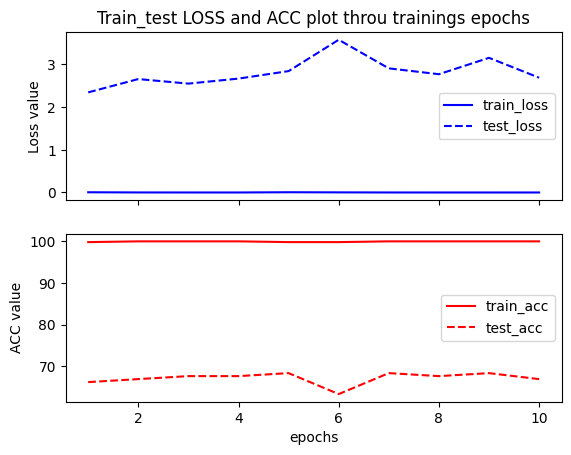

In [22]:
draw_test_train_plot(train_losses[-10:], train_accs[-10:], test_losses[-10:], test_epoch_acc[-10:])

## Modeling with augmentation

In [23]:
aug_img_train, aug_img_test, aug_y_train, aug_y_test = tts(aug_img_list,
                                                    aug_labels,                                        
                                                    train_size = train_percentage_div,
                                                   shuffle = True)

aug_y_train = aug_y_train.reset_index(drop = True)
train_tensor_label= torch.Tensor(aug_y_train)
aug_img_train = torch.Tensor(np.array(aug_img_train))
dataloader = get_image_dataloader(aug_img_train,
                                  train_tensor_label,
                                  batch_size=32,
                                  shuffle=True,
                                  num_workers=2)


aug_y_test = aug_y_test.reset_index(drop = True)
test_tensor_label = torch.Tensor(aug_y_test)
test_tensor_img = torch.Tensor(np.array(aug_img_test))
test_loader = get_image_dataloader(test_tensor_img,
                                   test_tensor_label,
                                   batch_size=32,
                                   shuffle=True,
                                   num_workers=2)

aug_model = ConvNet()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(aug_model.parameters(), lr=0.001)



aug_train_losses, aug_train_accs, aug_test_losses, aug_test_epoch_acc, _ = train_test_pt_model(aug_model,
                                                                            dataloader,
                                                                            test_loader,
                                                                            criterion,
                                                                            optimizer,
                                                                            epochs = 40)

<ipython-input-4-fa73f887303e>:158: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(train_loader, leave=False)


  0%|          | 0/174 [00:00<?, ?it/s]

Epoch #1	Train Loss: 2.64888 	Train ACC: 56.59222
Epoch #1	Test Loss: 0.73566 	Test ACC: 63.11239



  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

Epoch #11	Train Loss: 0.19448 	Train ACC: 91.60662
Epoch #11	Test Loss: 0.39981 	Test ACC: 84.36600



  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

Epoch #21	Train Loss: 0.01991 	Train ACC: 99.36959
Epoch #21	Test Loss: 0.44750 	Test ACC: 89.04899



  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

Epoch #31	Train Loss: 0.01705 	Train ACC: 99.33357
Epoch #31	Test Loss: 0.58587 	Test ACC: 89.19308



  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

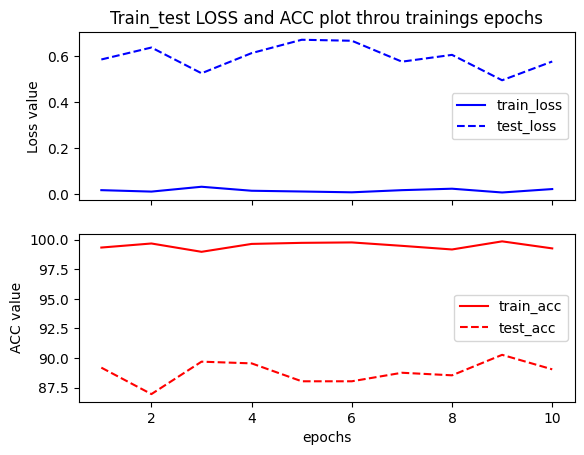

In [24]:
draw_test_train_plot(aug_train_losses[-10:], aug_train_accs[-10:], aug_test_losses[-10:], aug_test_epoch_acc[-10:])

# Save best model

In [25]:
saved_model_path = save_model(aug_model, 'saved_models', 'aug_model_0')


Model has been saved to: saved_models/aug_model_0.pth


In [26]:
print(saved_model_path)

saved_models/aug_model_0.pth


In [27]:
def load_model(model_class, saved_model_path):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  loaded_model = model_class
  loaded_model.load_state_dict(torch.load(saved_model_path))
  loaded_model.to(device)
  print(f"Loaded model structure:\n{loaded_model}\n\nModel on device:\n{next(loaded_model.parameters()).device}")
  return loaded_model

In [28]:
loaded_model = load_model(ConvNet(), saved_model_path)

Loaded model structure:
ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)

Model on device:
cuda:0


# Resnet transfer

In [34]:
data_dir = '/content/data'
train_mean, train_std = mean_std_average_color('/content/data/train')

Mean for all colors chanels: tensor([0.3310, 0.3396, 0.3441])
Standard deviation for all colors chanels: tensor([0.2151, 0.2187, 0.2197])


In [35]:
val_mean, val_std = mean_std_average_color('/content/data/validation')

Mean for all colors chanels: tensor([0.3310, 0.3396, 0.3441])
Standard deviation for all colors chanels: tensor([0.2151, 0.2187, 0.2197])


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transfered_model = models.resnet18(pretrained = True)
num_ftrs = transfered_model.fc.in_features
transfered_model.fc = torch.nn.Linear(num_ftrs, 2)
model_ft = transfered_model.to(device)
criterion_resnet = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 232MB/s]


In [36]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(128),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
     ]),
    'validation': transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(val_mean, val_std)
    ]),
}


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
class_names = image_datasets['train'].classes

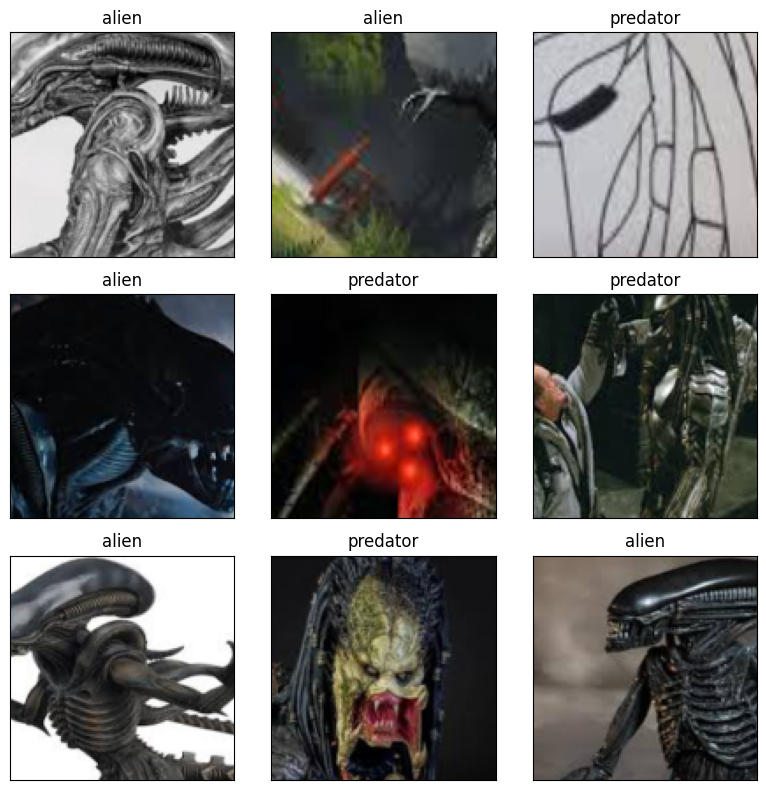

In [37]:
visualize_samples(dataloaders['train'],
                  class_names,
                  train_mean,
                  train_std
                  )

In [38]:
model_rn, train_acc, train_loss, val_acc, val_loss = train_model_rn(model_ft,
                       criterion_resnet,
                       optimizer,
                       exp_lr_scheduler,
                       num_epochs=50)

Epoch 1/50
----------
train Loss: 0.7705 Acc: 0.4885
validation Loss: 0.7109 Acc: 0.5150

Epoch 2/50
----------
train Loss: 0.7916 Acc: 0.4827
validation Loss: 0.7121 Acc: 0.5050

Epoch 3/50
----------
train Loss: 0.8065 Acc: 0.4755
validation Loss: 0.7166 Acc: 0.5050

Epoch 4/50
----------
train Loss: 0.7897 Acc: 0.4625
validation Loss: 0.7153 Acc: 0.4750

Epoch 5/50
----------
train Loss: 0.7909 Acc: 0.4683
validation Loss: 0.7124 Acc: 0.5200

Epoch 6/50
----------
train Loss: 0.7829 Acc: 0.5043
validation Loss: 0.7131 Acc: 0.5050

Epoch 7/50
----------
train Loss: 0.8061 Acc: 0.4452
validation Loss: 0.7156 Acc: 0.5150

Epoch 8/50
----------
train Loss: 0.8050 Acc: 0.4597
validation Loss: 0.7089 Acc: 0.4950

Epoch 9/50
----------
train Loss: 0.7847 Acc: 0.4683
validation Loss: 0.7188 Acc: 0.4850

Epoch 10/50
----------
train Loss: 0.7835 Acc: 0.4798
validation Loss: 0.7133 Acc: 0.5100

Epoch 11/50
----------
train Loss: 0.7787 Acc: 0.5014
validation Loss: 0.7147 Acc: 0.4850

Epoch 12

# Implement GRADIO

In [42]:
gr.Interface(fn=val_pt_model, 
             inputs=gr.inputs.Image(source="upload", label="Select a picture"),
             image=gr.inputs.Image(shape=(224, 224), image_mode='RGB'),
             outputs=[gr.outputs.Label(label="Class Name"), gr.outputs.Label(label="Probability")]).launch(debug=True,
                                                                                                           share = True )


/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:43: UserWarning: You have unused kwarg parameters in Interface, please remove them: {'image': image}
  warnings.warn(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://d7a3e31a8e938800ad.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://d7a3e31a8e938800ad.gradio.live
